## 测试与评估

**实验任务：**测试和评估预测泰坦尼克号乘客数据集中乘客生存情况的决策树模型

**实验课时：**1课时

**实验目的：**

* 了解测试与评估在机器学习中的作用；
* 理解常用模型性能指标的计算方法；
* 掌握计算模型性能指标的实现方法；
* 掌握ROC曲线分析的实现方法。

载入需要用到的程序包。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve
pd.set_option('mode.chained_assignment',None)

In [3]:
titanic3_file_path="./titanic3.xls"
titanic3 = pd.read_excel(titanic3_file_path)
titanic3.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


随机划分训练集和测试集。

In [17]:
X = titanic3[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
y = titanic3['survived']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 123)

填充训练集和测试集的缺失值。

In [18]:
imp = SimpleImputer(strategy='median')
train_X[['age','fare']] = imp.fit_transform(train_X[['age','fare']])
test_X[['age','fare']] = imp.transform(test_X[['age','fare']])

做训练集和测试集的独热编码。

In [19]:
categorical_cols = ['pclass','sex','embarked']
numeric_cols = list(set(X.columns) - set(categorical_cols))
ohe = OneHotEncoder(drop = 'first', sparse = False)
train_X = np.hstack((ohe.fit_transform(train_X[categorical_cols]), train_X[numeric_cols]))
cols = ["pclass_2nd","pclass_3rd","sex_male","embarked_Queenstown","embarked_Southampton","embarked_Unknown","sibsp","fare","parch","age"]
train_X = pd.DataFrame(train_X, columns = cols)
test_X = np.hstack((ohe.transform(test_X[categorical_cols]), test_X[numeric_cols]))
test_X = pd.DataFrame(test_X, columns = cols)
train_X.head()

,pclass_2nd,pclass_3rd,sex_male,embarked_Queenstown,embarked_Southampton,embarked_Unknown,sibsp,fare,parch,age
0,0.0,0.0,1.0,0.0,0.0,0.0,26.5500,0.0,0.0,35.0
1,0.0,1.0,1.0,0.0,1.0,0.0,16.1000,0.0,1.0,30.0
2,0.0,1.0,0.0,0.0,1.0,0.0,17.4000,0.0,1.0,36.0
3,0.0,1.0,1.0,0.0,0.0,0.0,18.7875,0.0,0.0,26.0
4,0.0,1.0,1.0,0.0,1.0,0.0,14.1083,0.0,2.0,41.0


训练最佳超参数的决策树模型。

In [20]:
clf = DecisionTreeClassifier(max_depth = 3, min_impurity_decrease = 0.005)
clf.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.005)

### 1. 测试模型

在训练集上做完超参数调优和模型训练后，需要在测试集上对模型做**一次性**公正的评估。

决策树模型有两个函数做预测，分别为：

* 函数`predict()`表示预测类别标签；
* 函数`predict_proba()`表示预测每个类别标签的概率。


调用决策树模型的函数`predict()`在测试集上预测类别标签，输入参数为测试集的自变量。

In [23]:
predict_y = clf.predict(test_X)
predict_y[:5]

array([1, 0, 1, 0, 0], dtype=int64)

调用决策树模型的函数`predict_proba()`在测试集上预测类别标签的概率，输入参数为测试集的自变量Numpy数组，输出为2列，第1列为阴性类别（标签为0）的预测概率，第2列为阳性类别（标签为1）的预测概率。

In [24]:
probas_y = clf.predict_proba(test_X)
probas_y[:5]

array([[0.4057971 , 0.5942029 ],
       [0.86956522, 0.13043478],
       [0.09036145, 0.90963855],
       [0.70503597, 0.29496403],
       [0.86956522, 0.13043478]])

在做更复杂的模型性能评估之前，先了解一些直观的性能指标。

精度并不一定是一个公正的衡量模型性能的指标。试想对于100个样本，其中99个阴性样本，1个阳性样本，如果全部预测为阴性样本，则模型的精度也可以达到99\%，然而这样的模型并不一定是我们想要的。

对于二分类问题，常用ROC曲线下面积（area under curve，AUC）作为模型性能指标，在介绍该指标之前，首先需要定义如下4种预测结果：

* 真阳性（true positive，TP）：预测为阳性，实际为阳性；
* 假阳性（false positive，FP）：预测为阳性，实际为阴性；
* 真阴性（true negative，TN）：预测为阴性，实际为阴性；
* 假阴性（false negative，FN）：预测为阴性，实际为阳性。

也可以通过下表呈现，并定义真阳性率（TPR）和假阳性率（FPR）。

- |预测为阳性  | 预测为阴性  |  -
------|------|------|------
实际为阳性  | 真阳性（TP）  | 假阴性（FN）  | 真阳性率（TPR = TP/(TP+FN)） 
实际为阴性  | 假阳性（FP）  | 真阴性（TN）  | 假阳性率（FPR = FP/(FP+TN)）  

另外常用的还有查准率（precision）、查全率（recall）和综合了两者的F1度量。

$$
\text{precision}=\frac{TP}{TP+FP}
$$
$$
\text{recall}=\frac{TP}{TP+FN}
$$

$$
F1=\frac{2\times \text{precision}\times \text{recall}}{\text{precision}+ \text{recall}}
$$

在程序包`sklearn.metrics`中对应了不同函数计算不同模型性能，主要包括：

* 函数`confusion_matrix()`表示混淆矩阵，即上表的真阳性、假阴性、假阳性和真阴性组成的矩阵；
* 函数`accuracy_score()`表示精度；
* 函数`precision_score()`表示查准率；
* 函数`recall_score()`表示查全率；
* 函数`f1_score()`表示F1度量。

其中

* 第1个参数`y_true`表示真实标签；
* 第2个参数`y_pred`表示预测标签。

In [25]:
confusion_matrix(test_y, predict_y)

array([[217,  27],
       [ 42, 107]], dtype=int64)

In [26]:
accuracy_score(test_y, predict_y)

0.8244274809160306

In [27]:
precision_score(test_y, predict_y)

0.7985074626865671

In [28]:
recall_score(test_y, predict_y)

0.7181208053691275

In [29]:
f1_score(test_y, predict_y)

0.7561837455830388

进一步的，可以调用程序包`sklearn.metrics`的函数`classification_report()`查看每个类的这些性能指标，行成分类性能报告。

In [30]:
print(classification_report(test_y, predict_y))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       244
           1       0.80      0.72      0.76       149

    accuracy                           0.82       393
   macro avg       0.82      0.80      0.81       393
weighted avg       0.82      0.82      0.82       393



### 2. 分类阈值

Scikit-learn中对于二分类问题，哪个类别概率大于0.5，则默认预测类别标签为哪个类。然而有些情况下，我们需要调节模型的灵敏度。例如，在交易反欺诈模型中，阈值设为0.5后我们发现过多的正常交易被分类为欺诈交易，影响了用户体验，这时我们需要提高欺诈交易的阈值，例如设为0.8，降低模型的灵敏度。

这里我们将阳性类的阈值设置为0.6，重新计算一些模型性能指标。

In [32]:
predict_y = (probas_y[:,1] > 0.6).astype(int)
confusion_matrix(test_y, predict_y)

array([[241,   3],
       [ 63,  86]], dtype=int64)

In [33]:
accuracy_score(test_y, predict_y)

0.8320610687022901

In [34]:
f1_score(test_y, predict_y)

0.7226890756302522

可以看出，精度略有提高，F1度量略有下降。

### 3. ROC分析

受试者工作特征曲线（receiver operating characteristic curve，ROC曲线），即假阳性率（FPR）为横轴、真阳性率（TPR）为纵轴所画出的曲线。分类阈值分别取0到1 中的各个数，计算不同阈值对应的FPR和TPR，描点得到ROC曲线。

ROC曲线下面积（AUC）会出现如下3种情况：

* $0.5<\text{AUC}<=1$时，模型优于随机猜测，设定合适的阈值则具有预测价值；
* $\text{AUC}=0.5$时，模型与随机猜测一致，无预测价值；
* $0<=\text{AUC}<0.5$时，模型差于随机猜测，但如果总是反预测而行，反而能产生预测价值。

调用程序包`sklearn.metrics`函数`roc_curve()`计算二分类问题中不同阈值对应的假阳性率（FPR）和真阳性率（TPR），其中

* 第1个参数`y_true`表示真实标签；
* 第2个参数`y_score`表示**阳性类别的预测概率**，而不是预测标签；
* 返回假阳性率（FPR）、真阳性率（TPR）和阈值。

In [35]:
fpr, tpr, thresholds = roc_curve(test_y, probas_y[:, 1])

绘制ROC曲线。

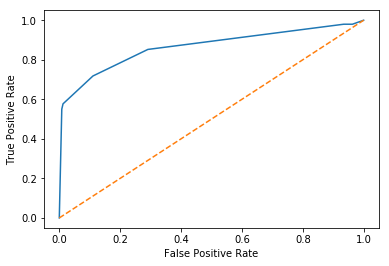

In [37]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

另有函数`roc_auc_score()`计算ROC曲线下面积，其中

* 第1个参数`y_true`表示真实标签；
* 第2个参数`y_score`表示阳性类别的预测概率。

In [38]:
roc_auc_score(test_y, probas_y[:, 1])

0.8639564308504787

类似ROC曲线，我们还经常会绘制x轴为查全率（recall）、y轴为查准率（precision）的PR曲线，同样是反映两种性能指标之间此消彼长的权衡关系。

调用序包`sklearn.metrics`函数`precision_recall_curve()`计算二分类问题中不同阈值对应的查全率（recall）和查准率（precision）。

In [40]:
precision, recall, thresholds = precision_recall_curve(test_y, probas_y[:, 1])

绘制PR曲线。

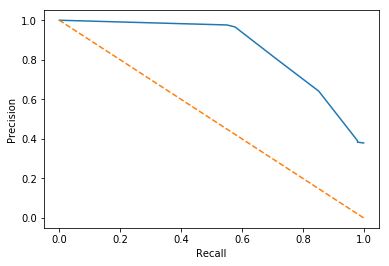

In [42]:
plt.figure()
plt.plot(recall, precision)
plt.plot([1,0], [0,1], linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()